## 🔮 Notebook 4 — Daily Batch Inference

Runs daily to generate next-day price predictions and update dashboard plots.

### Outputs
- Next-day hourly price forecast
- Plots saved to `docs/PricesDashboard/assets/img/`


In [1]:
# --- Imports ---
from pathlib import Path
import datetime
import json
import os
import sys
import warnings

import holidays
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor

import hopsworks
from dotenv import load_dotenv

warnings.filterwarnings("ignore")


# --- Project path ---
root_dir = Path("..").resolve()
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

from src.config import ElectricitySettings
from src import util


# --- Hopsworks login ---
env_path = root_dir / ".env"
load_dotenv(env_path)

settings = ElectricitySettings()
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

print("Successfully logged in to Hopsworks project:", settings.HOPSWORKS_PROJECT)


ElectricitySettings initialized
2025-12-27 18:23:37,761 INFO: Initializing external client
2025-12-27 18:23:37,761 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2025-12-27 18:23:39,328 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/127
Successfully logged in to Hopsworks project: ScalableProject


In [2]:
# Calendar
now_utc = pd.Timestamp.utcnow()


In [3]:
secrets = hopsworks.get_secrets_api()
area = json.loads(secrets.get_secret("ELECTRICITY_LOCATION_JSON").value)

PRICE_AREA = area["price_area"]
CITY = area["city"]
LATITUDE = area["latitude"]
LONGITUDE = area["longitude"]


In [4]:
mr = project.get_model_registry()

model_name = f"electricity_prices_xgboost_model_lags_{PRICE_AREA.lower()}"

EVALUATION_METRIC = "R squared"  # or "MSE"
SORT_METRICS_BY = "max"          # "max" for R squared, "min" for MSE
FALLBACK_VERSION = 3

retrieved_model = None
try:
    retrieved_model = mr.get_best_model(model_name, EVALUATION_METRIC, SORT_METRICS_BY)
    if retrieved_model is not None:
        print(
            f"Selected best model: {model_name} v{retrieved_model.version} "
            f"({EVALUATION_METRIC} / {SORT_METRICS_BY})"
        )
except Exception as e:
    print(
        f"Could not fetch best model automatically ({e}). "
        f"Falling back to version {FALLBACK_VERSION}."
    )

if retrieved_model is None:
    retrieved_model = mr.get_model(name=model_name, version=FALLBACK_VERSION)

if retrieved_model is None:
    raise RuntimeError(f"Model '{model_name}' not found in registry")

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()


Could not fetch best model automatically (Metadata operation error: (url: https://eu-west.cloud.hopsworks.ai/hopsworks-api/api/project/127/modelregistries/127/models). Server response: 
HTTP code: 500, HTTP reason: Internal Server Error, body: b'{"errorCode":120005,"usrMsg":"Invalid JSON path expression. The error is around character position 15.","errorMsg":"Persistence error occurred"}', error code: 120005, error msg: Persistence error occurred, user msg: Invalid JSON path expression. The error is around character position 15.). Falling back to version 3.


Downloading: 0.000%|          | 0/277550 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/89092 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115457 elapsed<00:00 remaining<?

In [5]:
# Model
retrieved_xgboost_model = XGBRegressor()
retrieved_xgboost_model.load_model(os.path.join(saved_model_dir, "model.json"))

retrieved_xgboost_model


XGBRegressor(base_score='6.099053E-1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'int', 'int', 'in...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
# --- Features ---
SEASON_MAP = {12: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3}

# Prices (history)
electricity_prices_fg = fs.get_feature_group("electricity_prices", version=2)
lookback_start = (pd.Timestamp.utcnow() - pd.Timedelta(days=4)).normalize()

hist_prices = (
    electricity_prices_fg.filter(
        (electricity_prices_fg.price_area == PRICE_AREA.lower())
        & (electricity_prices_fg.date >= lookback_start)
    )
    .read()
)

hist_prices["date"] = pd.to_datetime(hist_prices["date"], utc=True)
hist_prices = hist_prices.sort_values("unix_time")[
    ["price_area", "date", "hour", "unix_time", "price_sek"]
]

# Weather (forecast)
forecast_df = util.get_hourly_weather_forecast(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    city=PRICE_AREA.lower(),
    forecast_days=2,
)
forecast_df["date"] = pd.to_datetime(forecast_df["timestamp"], utc=True)
forecast_df["unix_time"] = forecast_df["date"].astype("int64") // 10**6
forecast_df["price_area"] = PRICE_AREA.lower()
forecast_df["price_area"] = forecast_df["price_area"].astype("string")
forecast_df = forecast_df.drop(columns=["timestamp", "city"], errors="ignore")

forecast_day = (pd.Timestamp.utcnow().normalize() + pd.Timedelta(days=1)).date()
forecast_df = forecast_df[forecast_df["date"].dt.date == forecast_day].copy()

forecast_df["weekday"] = forecast_df["date"].dt.weekday.astype("int8")
forecast_df["is_weekend"] = forecast_df["weekday"].isin([5, 6]).astype("int8")
forecast_df["month"] = forecast_df["date"].dt.month.astype("int8")
forecast_df["season"] = forecast_df["month"].map(SEASON_MAP).astype("int8")

try:
    years = range(forecast_df["date"].dt.year.min(), forecast_df["date"].dt.year.max() + 1)
    se_holidays = holidays.Sweden(years=years)
    forecast_df["is_holiday"] = forecast_df["date"].dt.date.isin(se_holidays).astype("int8")
except Exception:
    forecast_df["is_holiday"] = 0

# Lags
forecast_prices = forecast_df[["price_area", "date", "hour", "unix_time"]].copy()
forecast_prices["price_sek"] = np.nan

lag_base = (
    pd.concat(
        [
            hist_prices[["price_area", "date", "hour", "unix_time", "price_sek"]],
            forecast_prices,
        ],
        ignore_index=True,
    )
    .sort_values("unix_time")
)

for lag in (24, 48, 72):
    lag_base[f"price_lag_{lag}"] = lag_base.groupby("price_area")["price_sek"].shift(lag).astype("float32")

lag_base["price_roll3d"] = (
    lag_base.groupby("price_area")["price_sek"]
    .rolling(72, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .astype("float32")
)

lags_forecast = lag_base[lag_base["price_sek"].isna()][
    ["unix_time", "price_lag_24", "price_lag_48", "price_lag_72", "price_roll3d"]
]
forecast_df = forecast_df.merge(lags_forecast, on="unix_time", how="left")

# Model columns
forecast_df["electricity_prices_unix_time"] = forecast_df["unix_time"]
forecast_df["electricity_prices_weekday"] = forecast_df["weekday"]
forecast_df["electricity_prices_is_weekend"] = forecast_df["is_weekend"]
forecast_df["electricity_prices_month"] = forecast_df["month"]
forecast_df["electricity_prices_season"] = forecast_df["season"]
forecast_df["electricity_prices_is_holiday"] = forecast_df["is_holiday"]
forecast_df["electricity_prices_price_lag_24"] = forecast_df["price_lag_24"]
forecast_df["electricity_prices_price_lag_48"] = forecast_df["price_lag_48"]
forecast_df["electricity_prices_price_lag_72"] = forecast_df["price_lag_72"]
forecast_df["electricity_prices_price_roll3d"] = forecast_df["price_roll3d"]

feature_cols = [
    "price_area",
    "unix_time",
    "date",
    "hour",
    "temperature_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "cloud_cover",
    "wind_speed_10m",
    "wind_speed_100m",
    "wind_direction_10m",
    "wind_direction_100m",
    "wind_gusts_10m",
    "surface_pressure",
    "electricity_prices_unix_time",
    "electricity_prices_weekday",
    "electricity_prices_is_weekend",
    "electricity_prices_month",
    "electricity_prices_season",
    "electricity_prices_is_holiday",
    "electricity_prices_price_lag_24",
    "electricity_prices_price_lag_48",
    "electricity_prices_price_lag_72",
    "electricity_prices_price_roll3d",
]
forecast_df = forecast_df[feature_cols]

cat_cols = [c for c in forecast_df.columns if "price_area" in c]
X_pred = forecast_df.drop(columns=["date"] + cat_cols)

expected = getattr(retrieved_xgboost_model, "feature_names_in_", None)
if expected is None:
    try:
        expected = retrieved_xgboost_model.get_booster().feature_names
    except Exception:
        expected = None

if expected is not None:
    expected = list(expected)
    missing = [c for c in expected if c not in X_pred.columns]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    X_pred = X_pred[expected]

predictions = retrieved_xgboost_model.predict(X_pred)
forecast_df["predicted_price_sek"] = predictions.astype("float32")

print(forecast_df[["date", "hour", "predicted_price_sek"]].sort_values(["date", "hour"]).head(24))


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.97s) 
Fetching weather forecast for se3 (59.3251, 18.0711)...
Coordinates: 59.32889938354492°N 18.072357177734375°E
Elevation: 23.0 m asl
Fetched 48 hourly forecast records
                        date  hour  predicted_price_sek
0  2025-12-28 00:00:00+00:00     1             0.146682
1  2025-12-28 01:00:00+00:00     2             0.146682
2  2025-12-28 02:00:00+00:00     3             0.168444
3  2025-12-28 03:00:00+00:00     4             0.174157
4  2025-12-28 04:00:00+00:00     5             0.232880
5  2025-12-28 05:00:00+00:00     6             0.262411
6  2025-12-28 06:00:00+00:00     7             0.273658
7  2025-12-28 07:00:00+00:00     8             0.304050
8  2025-12-28 08:00:00+00:00     9             0.316132
9  2025-12-28 09:00:00+00:00    10             0.430684
10 2025-12-28 10:00:00+00:00    11             0.412257
11 2025-12-28 11:00:00+00:00    12             0.391307
12 2025-12-28 12:00

In [7]:
# Plot settings
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12})

img_path = os.path.join(root_dir, "docs/PricesDashboard/assets/img")
os.makedirs(img_path, exist_ok=True)

price_col = "predicted_price_sek" if "predicted_price_sek" in forecast_df.columns else "prediction"

print(f"Saving plots to: {img_path}")


Saving plots to: /Users/jesper/Documents/KTH/Skalbar_ML/Project/docs/PricesDashboard/assets/img


Graph saved to: /Users/jesper/Documents/KTH/Skalbar_ML/Project/docs/PricesDashboard/assets/img/electricity_price_signal.png


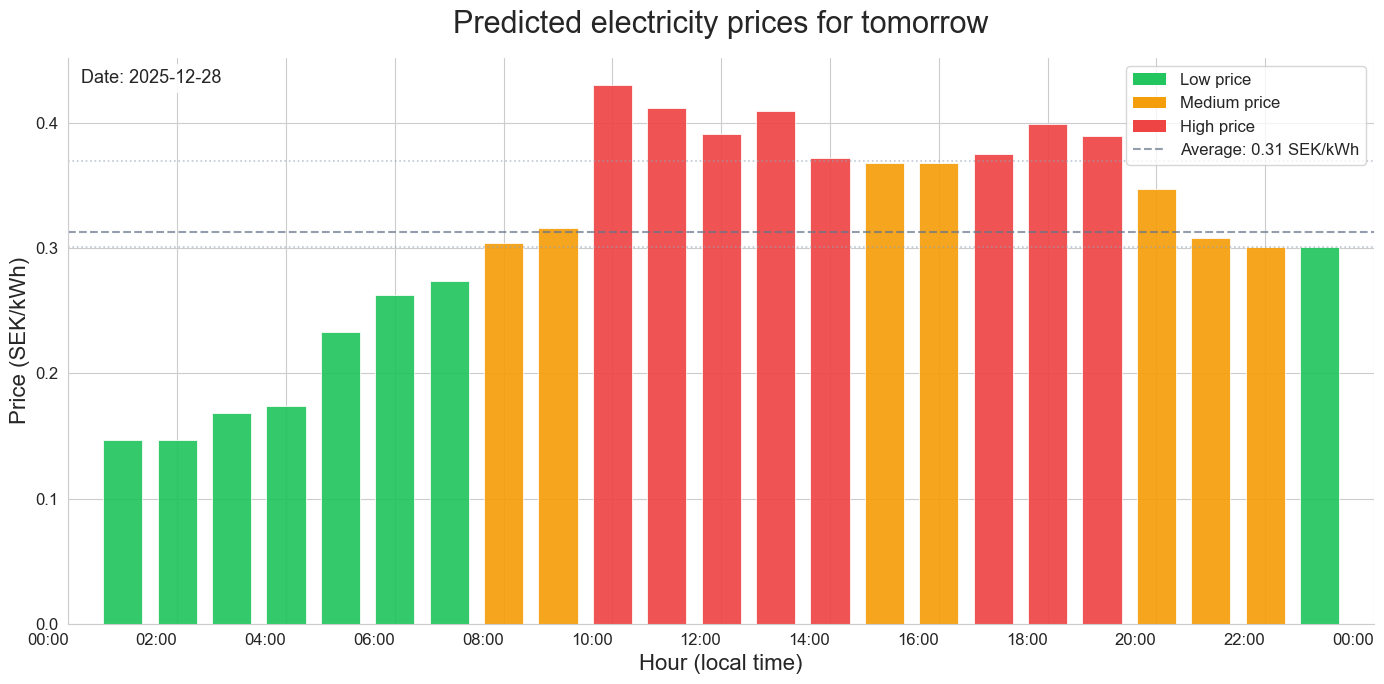

In [8]:
# Plot: forecast (tomorrow)
local_tz = "Europe/Stockholm"

forecast_plot = forecast_df.sort_values('date').copy()
forecast_plot['local_time'] = forecast_plot['date'].dt.tz_convert(local_tz)

# Pick tomorrow in local time to avoid UTC↔local off-by-one hour/day confusion
tomorrow_local_date = (pd.Timestamp.now(tz=local_tz).floor('D') + pd.Timedelta(days=1)).date()
forecast_plot = forecast_plot[forecast_plot['local_time'].dt.date == tomorrow_local_date].copy()

# Fallback (in case upstream filtering produced a different day)
if forecast_plot.empty:
    forecast_plot = forecast_df.sort_values('date').copy()
    forecast_plot['local_time'] = forecast_plot['date'].dt.tz_convert(local_tz)
    tomorrow_local_date = forecast_plot['local_time'].dt.date.mode().iloc[0]

forecast_plot = forecast_plot.sort_values('local_time')

# Price stages (low / medium / high) using tertiles
q_low, q_high = forecast_plot[price_col].quantile([0.33, 0.66])

def price_stage(p: float) -> str:
    if p <= q_low:
        return 'Low'
    if p <= q_high:
        return 'Medium'
    return 'High'

forecast_plot['stage'] = forecast_plot[price_col].apply(price_stage)
stage_colors = {
    'Low': '#22c55e',     # green
    'Medium': '#f59e0b',  # amber
    'High': '#ef4444',    # red
}
forecast_plot['color'] = forecast_plot['stage'].map(stage_colors)

mean_price = forecast_plot[price_col].mean()

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(
    forecast_plot['local_time'],
    forecast_plot[price_col],
    color=forecast_plot['color'],
    alpha=0.92,
    width=0.03,
    edgecolor='white',
    linewidth=0.6,
)

# Reference lines
ax.axhline(
    y=mean_price,
    color='#64748b',
    linestyle='--',
    alpha=0.7,
    linewidth=1.5,
    label=f'Average: {mean_price:.2f} SEK/kWh',
)
ax.axhline(y=q_low, color='#94a3b8', linestyle=':', alpha=0.6, linewidth=1.2)
ax.axhline(y=q_high, color='#94a3b8', linestyle=':', alpha=0.6, linewidth=1.2)

# Titles/labels (bigger font)
ax.set_title('Predicted electricity prices for tomorrow', fontsize=22, pad=18)
ax.set_xlabel('Hour (local time)', fontsize=16)
ax.set_ylabel('Price (SEK/kWh)', fontsize=16)
ax.tick_params(axis='both', labelsize=12)

# Date annotation
ax.text(
    0.01,
    0.98,
    f'Date: {tomorrow_local_date}',
    transform=ax.transAxes,
    va='top',
    ha='left',
    fontsize=13,
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'),
)

# Stage legend (Low/Medium/High)
from matplotlib.patches import Patch
stage_handles = [Patch(facecolor=stage_colors[k], edgecolor='none', label=f'{k} price') for k in ['Low', 'Medium', 'High']]
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=stage_handles + handles,
    loc='upper right',
    fontsize=12,
    frameon=True,
)

# Format x-axis as time-of-day
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=forecast_plot['local_time'].dt.tz))

# Force a full-day view: 00:00 → 00:00
start_local = pd.Timestamp(tomorrow_local_date, tz=local_tz)
ax.set_xlim(start_local, start_local + pd.Timedelta(days=1))

fig.autofmt_xdate(rotation=0)

sns.despine(ax=ax)
fig.tight_layout()

# Save + show in notebook
save_path = os.path.join(img_path, "electricity_price_signal.png")
fig.savefig(save_path, dpi=150)
print(f"Graph saved to: {save_path}")
plt.show()
plt.close(fig)


Graph saved to: /Users/jesper/Documents/KTH/Skalbar_ML/Project/docs/PricesDashboard/assets/img/feature_importance.png


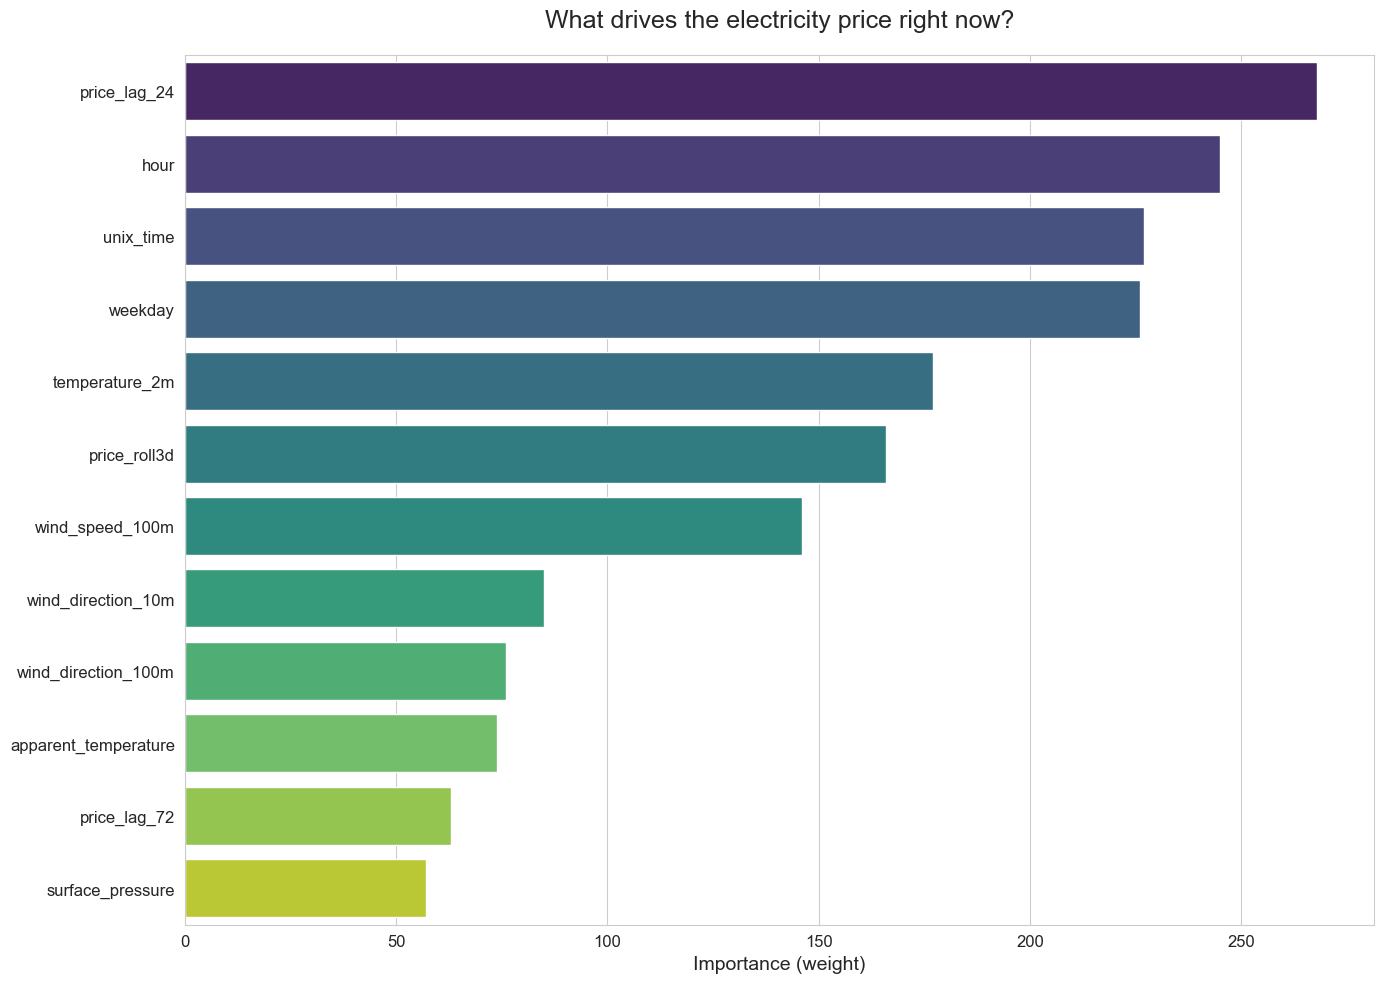

In [9]:
# Plot: feature importance
try:
    bst = retrieved_xgboost_model.get_booster()
    importance = bst.get_score(importance_type='weight')

    if not importance:
        importance = dict(zip(X_pred.columns, retrieved_xgboost_model.feature_importances_))

    imp_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Score'])
    imp_df['Feature'] = (
        imp_df['Feature']
        .str.replace('electricity_prices_', '')
        .str.replace('weather_', '')
    )
    imp_df = imp_df.sort_values(by='Score', ascending=False).head(12)

    fig, ax = plt.subplots(figsize=(14, 10))
    sns.barplot(x='Score', y='Feature', data=imp_df, palette='viridis', ax=ax)
    ax.set_title('What drives the electricity price right now?', fontsize=18, pad=20)
    ax.set_xlabel('Importance (weight)', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    fig.tight_layout()
    save_path = os.path.join(img_path, "feature_importance.png")
    fig.savefig(save_path, dpi=150)
    print(f"Graph saved to: {save_path}")
    plt.show()
    plt.close(fig)
except Exception as e:
    print(f"⚠️ Feature importance error: {e}")


Generating predicted vs actual history plot (last 7 days, ending yesterday)...
   Fetching price data from 2025-12-15...
Graph saved to: /Users/jesper/Documents/KTH/Skalbar_ML/Project/docs/PricesDashboard/assets/img/price_trend.png


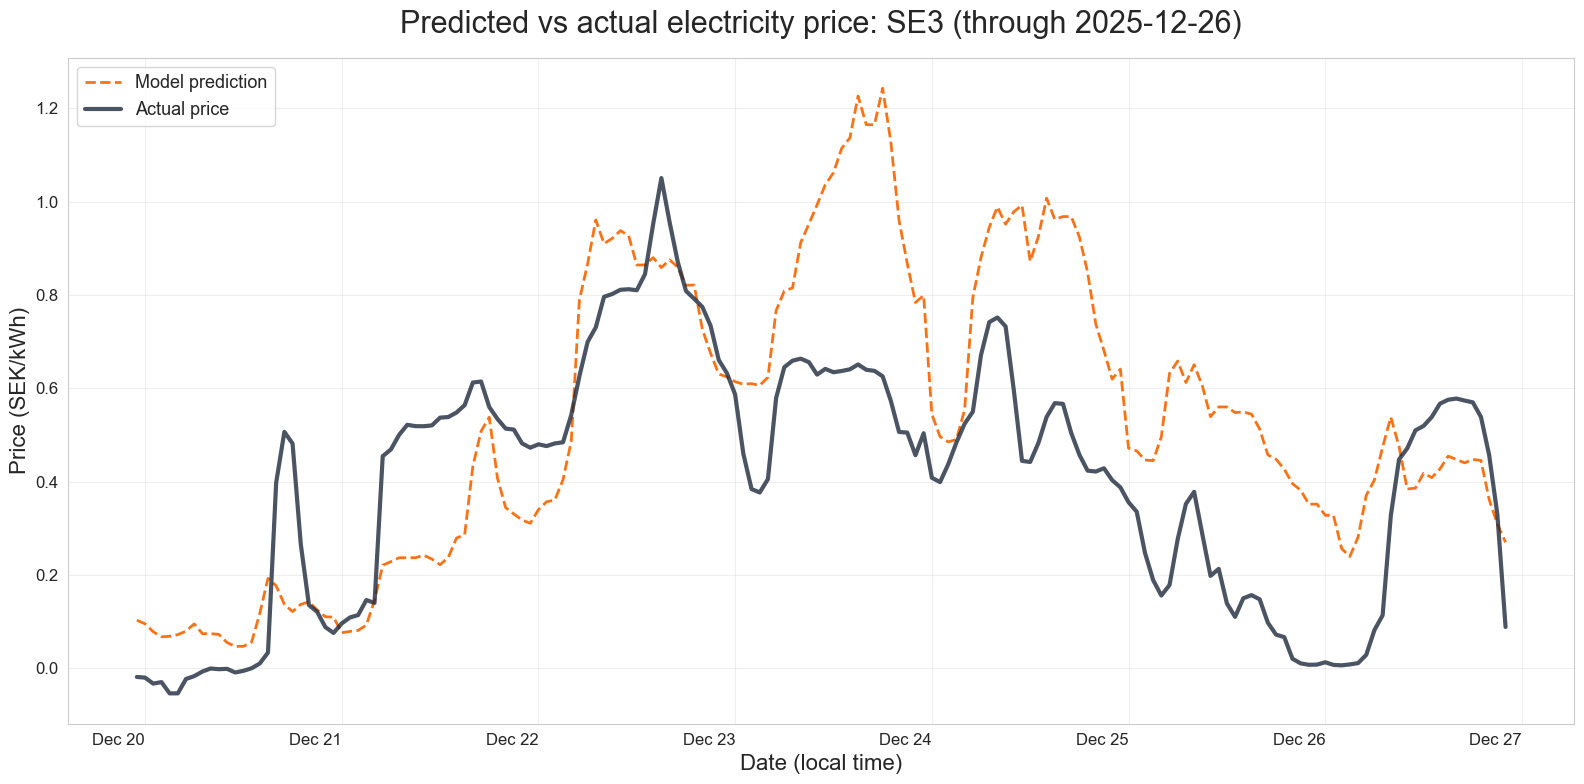

In [10]:
# Plot: predicted vs actual (history)
print("Generating predicted vs actual history plot (last 7 days, ending yesterday)...")

lag_buffer_days = 4

# Use local (Sweden) day boundaries so "last day" matches the calendar day you expect
local_tz = 'Europe/Stockholm'
now_local = pd.Timestamp.now(tz=local_tz)

# End at the start of today (local time) => plot ends at yesterday 24:00 local time
plot_end_time_local = now_local.floor('D')
plot_start_time_local = plot_end_time_local - pd.Timedelta(days=7)

# Convert boundaries to UTC for filtering (our stored timestamps are UTC)
plot_end_time = plot_end_time_local.tz_convert('UTC')
plot_start_time = plot_start_time_local.tz_convert('UTC')
fetch_start_time = plot_start_time - pd.Timedelta(days=lag_buffer_days)

last_complete_day = (plot_end_time_local - pd.Timedelta(days=1)).date()


# Fetch history
print(f"   Fetching price data from {fetch_start_time.date()}...")
hist_prices = electricity_prices_fg.filter(
    (electricity_prices_fg.price_area == PRICE_AREA.lower()) &
    (electricity_prices_fg.date >= fetch_start_time)
).read(online=True)

# Clean up types and duplicates
hist_prices['date'] = pd.to_datetime(hist_prices['date'], utc=True)
hist_prices['unix_time'] = hist_prices['date'].astype('int64') // 10**6
hist_prices = hist_prices.sort_values('unix_time').drop_duplicates(subset=['unix_time'])

# Keep 'date' to avoid merge issues later
hist_prices = hist_prices[['unix_time', 'price_sek', 'price_area', 'date']]

weather_fg = fs.get_feature_group('weather_hourly', version=2)
hist_weather = weather_fg.filter(weather_fg.date >= fetch_start_time).read(online=True)
hist_weather['date'] = pd.to_datetime(hist_weather['date'], utc=True)
hist_weather['unix_time'] = hist_weather['date'].astype('int64') // 10**6
hist_weather = hist_weather.sort_values('unix_time').drop_duplicates(subset=['unix_time'])


# Merge
full_df = hist_weather.merge(hist_prices.drop(columns=['date']), on='unix_time', how='left')

# Re-create date column from unix_time to be safe
full_df['date'] = pd.to_datetime(full_df['unix_time'], unit='ms', utc=True)
full_df['local_time'] = full_df['date'].dt.tz_convert(local_tz)
full_df['hour'] = full_df['date'].dt.hour.astype('int8')

# Lags
for _ in range(3):
    full_df['price_sek'] = full_df['price_sek'].fillna(full_df['price_sek'].shift(24))

full_df['price_lag_24'] = full_df['price_sek'].shift(24)
full_df['price_lag_48'] = full_df['price_sek'].shift(48)
full_df['price_lag_72'] = full_df['price_sek'].shift(72)
full_df['price_roll3d'] = full_df['price_sek'].rolling(72, min_periods=1).mean()


# Calendar
full_df['weekday'] = full_df['date'].dt.weekday.astype('int8')
full_df['is_weekend'] = full_df['weekday'].isin([5, 6]).astype('int8')
full_df['month'] = full_df['date'].dt.month.astype('int8')
full_df['season'] = full_df['month'].map(SEASON_MAP).astype('int8')
full_df['is_holiday'] = 0
full_df['price_area'] = PRICE_AREA.lower()

# Map column names for the model
full_df['electricity_prices_unix_time'] = full_df['unix_time']
full_df['electricity_prices_weekday'] = full_df['weekday']
full_df['electricity_prices_is_weekend'] = full_df['is_weekend']
full_df['electricity_prices_month'] = full_df['month']
full_df['electricity_prices_season'] = full_df['season']
full_df['electricity_prices_is_holiday'] = full_df['is_holiday']
full_df['electricity_prices_price_lag_24'] = full_df['price_lag_24']
full_df['electricity_prices_price_lag_48'] = full_df['price_lag_48']
full_df['electricity_prices_price_lag_72'] = full_df['price_lag_72']
full_df['electricity_prices_price_roll3d'] = full_df['price_roll3d']


# Predict
plot_df = full_df[(full_df['date'] >= plot_start_time) & (full_df['date'] < plot_end_time)].copy()
X_all = plot_df[retrieved_xgboost_model.feature_names_in_].copy()
plot_df['predicted_price'] = retrieved_xgboost_model.predict(X_all)

real_history = hist_prices[(hist_prices['date'] >= plot_start_time) & (hist_prices['date'] < plot_end_time)].copy()
real_history['local_time'] = real_history['date'].dt.tz_convert(local_tz)


# 6. PLOT
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(
    x='local_time', y='predicted_price', data=plot_df,
    label='Model prediction', color='#f97316', linewidth=2, linestyle='--', ax=ax
)

sns.lineplot(
    x='local_time', y='price_sek', data=real_history,
    label='Actual price', color='#1e293b', linewidth=3, alpha=0.8, ax=ax
)

# Cleaner x-axis formatting (make "dates" explicit)
tzinfo = plot_df['local_time'].dt.tz
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=tzinfo))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

# Larger fonts
ax.set_title(
    f'Predicted vs actual electricity price: {PRICE_AREA} (through {last_complete_day})',
    fontsize=22,
    pad=18,
)
ax.set_ylabel('Price (SEK/kWh)', fontsize=16)
ax.set_xlabel('Date (local time)', fontsize=16)
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc='upper left', fontsize=13)
ax.grid(True, alpha=0.3)

fig.autofmt_xdate(rotation=0)
fig.tight_layout()

# Save + show in notebook
save_path = os.path.join(img_path, "price_trend.png")
fig.savefig(save_path, dpi=150)
print(f"Graph saved to: {save_path}")
plt.show()
plt.close(fig)
